In [1]:
!pip install casadi
from IPython.display import clear_output
import os
import time

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

In [2]:
# gros+ example 13.1
nu = 1 #制御変数の次元
nx = 2 #状態変数の次元

# コスト関数の重み
Q = casadi.diag([1,10])
Q_f = casadi.diag([1,10])*1
R = casadi.diag([1])

# 予測ホライズン等
T = 5
K = 20
dt = T/K

# 制約条件
x_lb = [-1,-np.inf]
x_ub = [np.inf,np.inf]
u_lb = [-1]
u_ub = [np.inf]

total = nx*(K+1) + nu*K

In [3]:
def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    x1 = states[0]
    x2 = states[1]
    u = ctrls[0]

    x1_dot = x1*x2 + u
    x2_dot = x1
    
    states_dot = casadi.vertcat(x1_dot,x2_dot)

    f = casadi.Function("f",[states,ctrls],[states_dot],['x','u'],['x_dot'])
    return f

def make_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    r1 = f(x=states,u=ctrls)["x_dot"]
    r2 = f(x=states+dt*r1/2,u=ctrls)["x_dot"]
    r3 = f(x=states+dt*r2/2,u=ctrls)["x_dot"]
    r4 = f(x=states+dt*r3,u=ctrls)["x_dot"]

    states_next = states + dt*(r1+2*r2+2*r3+r4)/6

    RK4 = casadi.Function("RK4",[states,ctrls],[states_next],["x","u"],["x_next"])
    return RK4

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]

    dae = {"x":states,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(x,u):
    cost = (casadi.dot(Q@x,x) + casadi.dot(R@u,u)) / 2
    return cost

def compute_terminal_cost(x):
    cost = casadi.dot(Q_f@x,x) / 2
    return cost

In [4]:
def make_nlp_multiple():
    RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k]) * dt
        eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_terminal_cost(X[-1])

    option = {'print_time':False}
    nlp = {"x":casadi.vertcat(*X,*U),
           "f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

def make_nlp_single():
    RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    x_init = casadi.SX.sym("x_init",nx)

    J = 0

    x_tmp = x_init
    for k in range(K):
        J += compute_stage_cost(x_tmp,U[k]) * dt
        x_tmp = RK4(x=x_tmp,u=U[k])["x_next"]
    J += compute_terminal_cost(x_tmp)
    option = {'print_time':False}
    nlp = {"x":casadi.vertcat(x_init,*U),
           "f":J}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

In [5]:
S_multiple = make_nlp_multiple()
S_single = make_nlp_single()

In [6]:
def compute_optimal_control_multiple(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

def compute_optimal_control_single(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + u_lb*K
    ubx = x_init + u_ub*K
    res = S(lbx=lbx,ubx=ubx,x0=x0)
    
    offset = nx
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [7]:
x_init = casadi.DM([0,1])


In [8]:

x0_single = casadi.DM.zeros(nx + nu*K)
u_opt, x0_single = compute_optimal_control_single(S_single,x_init,x0_single)

x0_multiple = casadi.DM.zeros(total)
u_opt, x0_multiple = compute_optimal_control_multiple(S_multiple,x_init,x0_multiple)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      210

Total number of variables............................:       20
                     variables with only lower bounds:       20
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

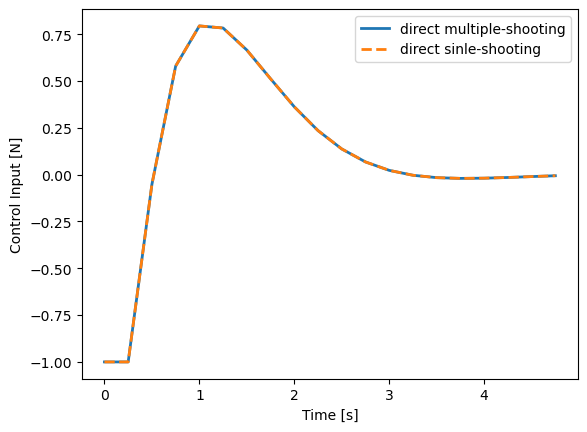

In [9]:
timestamp = np.array(range(K))* dt
plt.plot(timestamp, x0_multiple[nx*(K+1):],linewidth=2,label="direct multiple-shooting")
plt.plot(timestamp, x0_single[nx:],"--",linewidth=2,label="direct sinle-shooting")
plt.xlabel("Time [s]")
plt.ylabel("Control Input [N]")
plt.legend()
plt.savefig("images/chap6_shooting_control_trajectory.png")

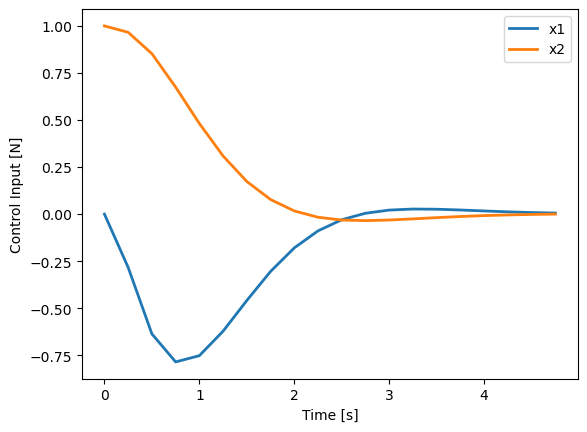

In [10]:
timestamp = np.array(range(K))* dt
plt.plot(timestamp, x0_multiple[:nx*(K)][::nx],linewidth=2,label="x1")
plt.plot(timestamp, x0_multiple[1:nx*(K)+1][::nx],linewidth=2,label="x2")
# plt.plot(timestamp, x0_single[:nx*(K)][::nx],"--",linewidth=2,label="direct sinle-shooting")
plt.xlabel("Time [s]")
plt.ylabel("Control Input [N]")
plt.legend()
plt.savefig("images/chap6_shooting_control_trajectory.png")